# DNN 

In [1]:
import logging, os, warnings
import numpy as np
import pandas as pd
import my_trace as tc
import tensorflow as tf
from sklearn.utils import shuffle
from data_helper import XY_from_df
from sklearn.model_selection import StratifiedKFold
from bincls import BinaryClassificationAverageReport
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# tensorflow only show Error
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
# sklearn ignore warnings
warnings.filterwarnings('ignore')

## Experiments
- baseline: nothing deal with unbalanced issue
- class_weight: the sum of the weights of all examples stays the same
- upsampling: add one more minjority data.

In [3]:
SEED = 5
FOLD = 10
TRAIN_PATH = "../dataset/train.csv"
TARGET_NAMES = ["bad", "good"]

np.random.seed(SEED)
tf.random.set_seed(SEED)
stratified_folder = StratifiedKFold(n_splits=FOLD, random_state=SEED, shuffle=False)

df_train = pd.read_csv(TRAIN_PATH)
X, Y = XY_from_df(df_train)

features = [feat for feat in df_train.columns][1:]


## Model Struture

> After tunnung the model structure, three of experiments performance well in this structure.
- Structure: 64_RELU -> 32_RELU_D5 -> 16_RELU_D5 -> 1 (with L2=0.005)
- Optimizer: Adam with learning rate 0.005
- Loss Function: BCE (Binary Cross Entropy)

In [6]:
def get_model():
    model = tf.keras.Sequential([
        
    tf.keras.layers.Dense(64, activation=None,kernel_regularizer=tf.keras.regularizers.l2(l=0.005)),
    tf.keras.layers.ReLU(),
#     tf.keras.layers.Dropout(0.1, seed=SEED),
        
    tf.keras.layers.Dense(32, activation=None,kernel_regularizer=tf.keras.regularizers.l2(l=0.005)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.5, seed=SEED),
        
    tf.keras.layers.Dense(16, activation=None,kernel_regularizer=tf.keras.regularizers.l2(l=0.005)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.5, seed=SEED),
        
    tf.keras.layers.Dense(1,activation=None,kernel_regularizer=tf.keras.regularizers.l2(l=0.005)),
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005,name='adam'),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['acc'])

    return model

## 10 cross validation

In [5]:
def cross_valid_process_tf(stratified_folder, X, Y, report, title, mode, up):
    
    def upsampling(X,Y,train_index):
        pos = []
        for i, t in enumerate(Y[train_index]):
            if t == 0: pos.append(i)
        X_new = np.append(X[train_index], X[pos], axis=0)
        Y_new = np.append(Y[train_index], Y[pos], axis=0)
        idxs = [i for i in range(len(Y_new))]
        idxs = shuffle(idxs, random_state=3)
        return X_new[idxs], Y_new[idxs]
    
    # Scaling by total/2 helps keep the loss to a similar magnitude.
    # The sum of the weights of all examples stays the same.
    def get_class_weight(Y):
        pos, neg = 0, 0
        for y in Y:
            if y == 0: pos += 1
            if y == 1: neg += 1
        total = neg + pos
        weight_for_0 = (1 / neg)*(total)/2.0 
        weight_for_1 = (1 / pos)*(total)/2.0
        return {0: weight_for_0, 1: weight_for_1}

    fold = 0
    
    for train_index, valid_index in stratified_folder.split(X, Y):
        fold += 1
        model = get_model()
        history = tc.MetricsCallback((X[valid_index],Y[valid_index]), title)
        
        if title == "class_weight":
            class_weight = get_class_weight(Y[train_index])
        else:
            class_weight = {0:1.,1:1.}
        
        if up:
            X_train ,Y_train = upsampling(X,Y,train_index)
        else:
            X_train ,Y_train = X[train_index], Y[train_index]
            
        if mode == "report": print("fold", end=" ")

        model.fit(X_train, Y_train, epochs=150, batch_size=64,\
              verbose=0, callbacks=[history], validation_data=(X[valid_index], Y[valid_index]),\
              class_weight=class_weight)

        Y_valid_pred = model.predict_classes(X[valid_index])
        cm = confusion_matrix(Y[valid_index], Y_valid_pred)
        report.cm_append(cm)
        history.plot(fold)
    if mode == "report":
        report.avg_cm_report()
        return None
    if mode == "obj":
        return report.object_score()

fold . . . . . . . . . . . . . . . 

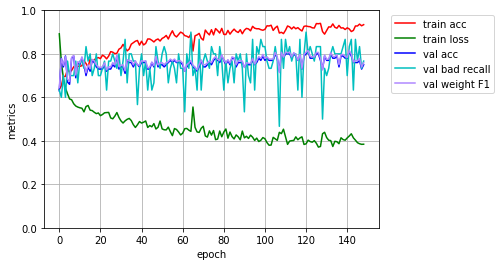

fold . . . . . . . . . . . . . . . 

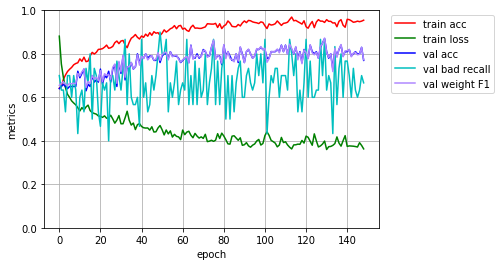

fold . . . . . . . . . . . . . . . 

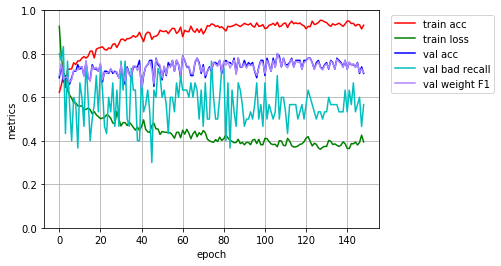

fold . . . . . . . . . . . . . . . 

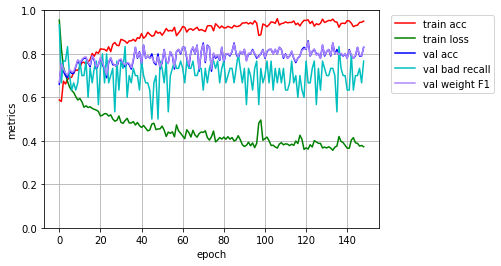

fold . . . . . . . . . . . . . . . 

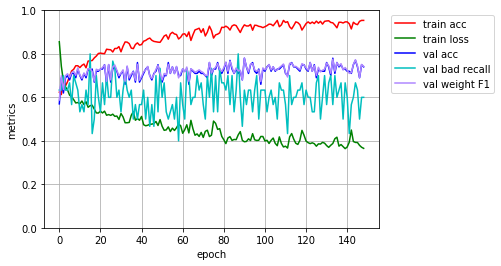

fold . . . . . . . . . . . . . . . 

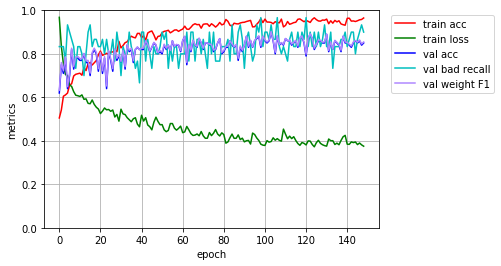

fold . . . . . . . . . . . . . . . 

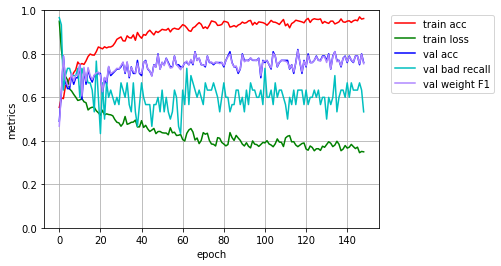

fold . . . . . . . . . . . . . . . 

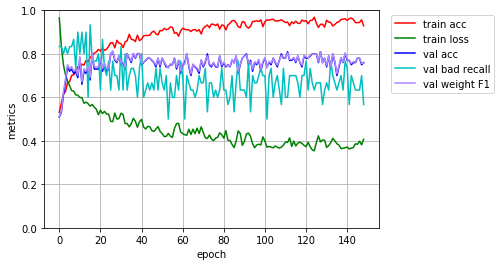

fold . . . . . . . . . . . . . . . 

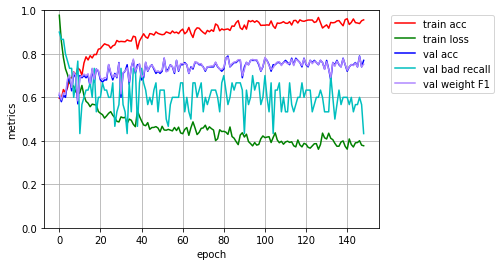

fold . . . . . . . . . . . . . . . 

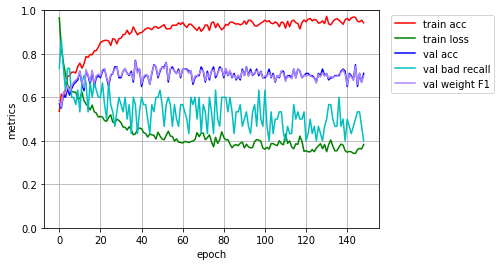



Below number are the average of 10 fold.

bad
             precision:    60.62%
                recall:    62.00%
                    F1:    60.57%
good
             precision:    83.95%
                recall:    82.71%
                    F1:    83.14%
---------------------------------
             weight_F1:    76.37%
                   acc:    76.50%



In [6]:
report = BinaryClassificationAverageReport(TARGET_NAMES)
cross_valid_process_tf(stratified_folder, X, Y, report, 'upsampling', "report", True)

## Select best epoch performance for each experiment

In [16]:
def cross_valid_process_predict(stratified_folder, X, Y, report, mode, up, title, model_epoch):
    
    
    def upsampling(X,Y,train_index):
        pos = []
        for i, t in enumerate(Y[train_index]):
            if t == 0: pos.append(i)
        X_new = np.append(X[train_index], X[pos], axis=0)
        Y_new = np.append(Y[train_index], Y[pos], axis=0)
        idxs = [i for i in range(len(Y_new))]
        idxs = shuffle(idxs, random_state=3)
        return X_new[idxs], Y_new[idxs]
    
    def get_class_weight(Y):
        pos, neg = 0, 0
        for y in Y:
            if y == 0: pos += 1
            if y == 1: neg += 1
        total = neg + pos
        weight_for_0 = (1 / neg)*(total)/2.0 
        weight_for_1 = (1 / pos)*(total)/2.0
        return {0: weight_for_0, 1: weight_for_1}

    fold = 0
    
    MODEL_PATH = 'models/{}/{}/my_model'.format(title, str(model_epoch))
    print(MODEL_PATH)

       
    for train_index, valid_index in stratified_folder.split(X, Y):
        fold += 1
        model = get_model()
        model.load_weights(MODEL_PATH)
        
        class_weight = get_class_weight(Y[train_index])
        
        if up:
            X_train ,Y_train = upsampling(X,Y,train_index)
        else:
            X_train ,Y_train = X[train_index], Y[train_index]
            
        if mode == "report": print("fold", end=" ")

        Y_valid_pred = model.predict_classes(X[valid_index])
        cm = confusion_matrix(Y[valid_index], Y_valid_pred)
        report.cm_append(cm)
        
    if mode == "report":
        report.avg_cm_report()
        return None
    if mode == "obj":
        return report.object_score()

In [17]:
report = BinaryClassificationAverageReport(TARGET_NAMES)
cross_valid_process_predict(stratified_folder, X, Y, report, 'report', False, "upsampling", 40)

models/upsampling/40/my_model
fold fold fold fold fold fold fold fold fold fold 

Below number are the average of 10 fold.

bad
             precision:    81.30%
                recall:    93.33%
                    F1:    86.73%
good
             precision:    97.13%
                recall:    90.86%
                    F1:    93.84%
---------------------------------
             weight_F1:    91.71%
                   acc:    91.60%



In [18]:
def model_score(bad_recall, w_F1):
    score = 0.6 * bad_recall + 0.4 * w_F1
    print("model score:",score)

model_score(0.93, 0.91)

model score: 0.9220000000000002


# Report Summary

Choose three different way to predict, below are the comparison.

## baseline

> models/baseline/40/my_model

```
Below number are the average of 10 fold.

bad
             precision:    77.37%
                recall:    69.33%
                    F1:    72.91%
good
             precision:    87.52%
                recall:    91.29%
                    F1:    89.32%
---------------------------------
             weight_F1:    84.40%
                   acc:    84.70%

model score: 0.75

```

### class weight

> models/class_weight/80/my_model

```
fold fold fold fold fold fold fold fold fold fold 

Below number are the average of 10 fold.

bad
             precision:    83.42%
                recall:    81.00%
                    F1:    82.07%
good
             precision:    92.11%
                recall:    93.29%
                    F1:    92.67%
---------------------------------
             weight_F1:    89.49%
                   acc:    89.60%
                   
                   
model score: 0.8420000000000001
```

### up sampling

> models/upsampling/40/my_model

```
fold fold fold fold fold fold fold fold fold fold 

Below number are the average of 10 fold.

bad
             precision:    81.30%
                recall:    93.33%
                    F1:    86.73%
good
             precision:    97.13%
                recall:    90.86%
                    F1:    93.84%
---------------------------------
             weight_F1:    91.71%
                   acc:    91.60%

model score: 0.9220000000000002

```


